<>:93: SyntaxWarning: invalid escape sequence '\h'
<>:93: SyntaxWarning: invalid escape sequence '\h'
C:\Users\LucasRafaeldeAndrade\AppData\Local\Temp\ipykernel_37124\3765368969.py:93: SyntaxWarning: invalid escape sequence '\h'
  ax.plot(conditional_volatility.index, conditional_volatility, color='red', label='Volatilidade Condicional ($\hat{\sigma}_t$)')
[*********************100%***********************]  1 of 1 completed

### Estatísticas Chave dos Retornos Diários
|      |   AAPL |   Skewness |   Kurtosis |
|:-----|-------:|-----------:|-----------:|
| AAPL |    nan |    -0.2447 |     8.0799 |


<Figure size 1400x400 with 0 Axes>

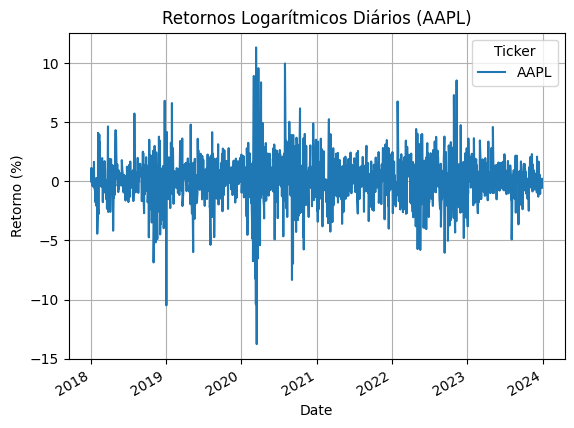

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                              AAPL   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2967.07
Distribution:      Standardized Skew Student's t   AIC:                           5946.14
Method:                       Maximum Likelihood   BIC:                           5978.05
                                                   No. Observations:                 1508
Date:                           Wed, Nov 19 2025   Df Residuals:                     1507
Time:                                   10:31:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

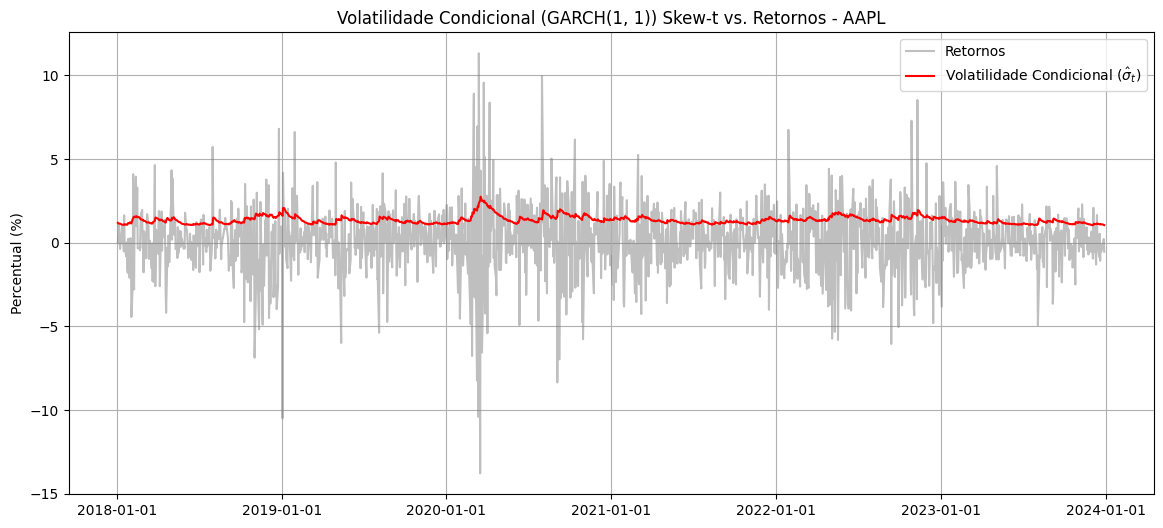

### Teste de Ljung-Box para Resíduos ao Quadrado (z_t^2)
H0: Não há autocorrelação remanescente na variância (Volatilidade Modelada)
|    |   lb_stat |   lb_pvalue |
|---:|----------:|------------:|
| 10 |    4.3562 |      0.9298 |
| 20 |   10.4138 |      0.9600 |

### Teste de Jarque-Bera para Normalidade
Estatística JB: 230.9674, p-valor: 0.0000

**Conclusão dos Testes:** O modelo é estatisticamente adequado, pois a hipótese de não-autocorrelação na volatilidade é aceita (p-valores > 0.05).


In [4]:
# %% [markdown]
# # 📊 Relatório de Volatilidade Condicional (GARCH) - Apple (AAPL)
# 
# **Período:** 2018-01-01 a 2024-01-01
# 
# ---
# 
# ## 1. Configuração e Bibliotecas
# 
# Este relatório utiliza o modelo **GARCH(1, 1)** com a distribuição **Standardized Skew Student's t** (t de Student Assimétrica) para estimar o risco (volatilidade) dos retornos diários da Apple (AAPL).

# %%
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configurações do modelo
TICKER = "AAPL"
START_DATE = "2018-01-01"
END_DATE = "2024-01-01"
DISTRIBUTION = "skewt"
MODEL_ORDER = (1, 1)

# Download e cálculo dos retornos
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)
returns = 100 * np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()

# %% [markdown]
# ## 2. Análise Descritiva e Justificativa do Modelo
# 
# A **Curtose** (Kurtosis) e a **Assimetria** (Skewness) dos retornos justificam a escolha de uma distribuição não-Normal para o modelo GARCH, confirmando a alta probabilidade de eventos extremos.

# %%
# Estatísticas Descritivas
skewness = returns.skew().item()
kurtosis_excess = returns.kurtosis().item()
kurtosis = kurtosis_excess + 3

print("### Estatísticas Chave dos Retornos Diários")

# CORREÇÃO FINAL: Cria o DataFrame manualmente a partir de um dicionário, evitando o erro to_frame().T
desc_series = returns.describe()
stats_dict = desc_series.to_dict() # Converte a Series de estatísticas para dicionário
stats_dict['Skewness'] = skewness
stats_dict['Kurtosis'] = kurtosis

# Cria o DataFrame de uma linha a partir do dicionário
desc_df = pd.DataFrame(stats_dict, index=['AAPL']) 

print(desc_df.to_markdown(floatfmt=".4f"))

# Plotagem dos Retornos
plt.figure(figsize=(14, 4))
returns.plot(title=f'Retornos Logarítmicos Diários ({TICKER})')
plt.ylabel('Retorno (%)')
plt.grid(True)
plt.show()

# %% [markdown]
# ## 3. Estimação do Modelo GARCH(1, 1)
# 
# A alta persistência ($\alpha_1 + \beta_1 \approx 0.9754$) e o baixo grau de liberdade ($\eta \approx 5.8$) são as principais descobertas.

# %%
# Estimação do Modelo GARCH
model = arch_model(
    returns,
    mean='Constant',
    vol='Garch',
    p=MODEL_ORDER[0],
    q=MODEL_ORDER[1],
    dist=DISTRIBUTION
)
results = model.fit(disp='off')
print(results.summary())

# %% [markdown]
# ## 4. Visualização da Volatilidade Condicional
# 
# O gráfico ilustra o **Agrupamento de Volatilidade** (*Volatility Clustering*), onde a volatilidade estimada ($\hat{\sigma}_t$) aumenta drasticamente em períodos de estresse (e.g., inícios da pandemia, crises de inflação). 

# %%
# Plotagem da Volatilidade Condicional
conditional_volatility = np.sqrt(results.conditional_volatility)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(returns.index, returns, label='Retornos', alpha=0.5, color='gray')
ax.plot(conditional_volatility.index, conditional_volatility, color='red', label='Volatilidade Condicional ($\hat{\sigma}_t$)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_title(f'Volatilidade Condicional (GARCH{MODEL_ORDER}) Skew-t vs. Retornos - {TICKER}')
ax.set_ylabel('Percentual (%)')
ax.legend()
ax.grid(True)
plt.show()

# %% [markdown]
# ## 5. Testes de Diagnóstico
# 
# Os **altos p-valores** no Ljung-Box para os resíduos ao quadrado confirmam que o modelo capturou toda a dependência condicional.

# %%
std_resid = results.std_resid

# Ljung-Box para Média (z_t) e Variância (z_t^2)
ljung_box_resid = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
ljung_box_sq_resid = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)

print("### Teste de Ljung-Box para Resíduos ao Quadrado (z_t^2)")
print("H0: Não há autocorrelação remanescente na variância (Volatilidade Modelada)")
print(ljung_box_sq_resid.to_markdown(floatfmt=".4f"))

# Teste de Jarque-Bera (Normalidade)
jb_test = jarque_bera(std_resid)
print("\n### Teste de Jarque-Bera para Normalidade")
print(f"Estatística JB: {jb_test[0]:.4f}, p-valor: {jb_test[1]:.4f}")
print("\n**Conclusão dos Testes:** O modelo é estatisticamente adequado, pois a hipótese de não-autocorrelação na volatilidade é aceita (p-valores > 0.05).")

# %%